<a href="https://colab.research.google.com/github/haladaher2024/ML_project/blob/main/notebooks/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/haladaher2024/ML_project.git


Cloning into 'ML_project'...
remote: Enumerating objects: 1771, done.
remote: Counting objects: 100% (1771/1771), done.
remote: Compressing objects: 100% (930/930), done.
remote: Total 1771 (delta 3), reused 1758 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1771/1771), 3.06 MiB | 28.24 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Handling missing labels

In [26]:
import os
from collections import Counter

# Define paths
image_folder = '/content/ML_project/data/images'
label_folder = '/content/ML_project/data/labels'

# Step 1: List files
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))

# Step 2: Get base filenames (without .jpg/.txt)
image_basenames = {os.path.splitext(f)[0] for f in image_files}
label_basenames = {os.path.splitext(f)[0] for f in label_files}

# Step 3: Identify unmatched images
missing_labels = image_basenames - label_basenames
missing_count = len(missing_labels)
total_images = len(image_basenames)
missing_percentage = (missing_count / total_images) * 100


print(f"Total images: {total_images}")
print(f"Missing labels: {missing_count}")
print(f"Missing %: {missing_percentage:.2f}%")

# Step 4: Delete unmatched images if < 5%
if missing_percentage < 5:
    print("Remove unmatched images")
    for name in missing_labels:
        img_path = os.path.join(image_folder, name + ".jpg")
        if os.path.exists(img_path):
            os.remove(img_path)
else:
    print("Too many missing labels  we cant drop the images, consider alternative strategy.")

# Step 5: Final count check
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))
print(f" Final image count: {len(image_files)}")
print(f" Final label count: {len(label_files)}")


🧼 MISSING LABEL CLEANUP
Total images: 893
Missing labels: 15
Missing %: 1.68%
🗑️ Removing unmatched images...
✅ Final image count: 878
✅ Final label count: 878


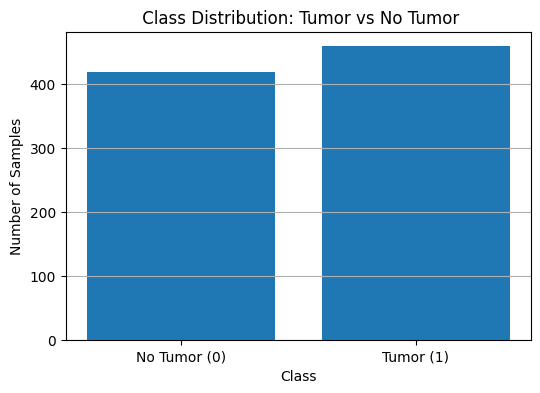


Data is balanced


In [33]:
import matplotlib.pyplot as plt


from collections import Counter
label_folder = '/content/ML_project/data/labels'
label_counts = Counter()

for file in os.listdir(label_folder):
    with open(os.path.join(label_folder, file), 'r') as f:
        line = f.readline().strip()
        if line:
            label = int(line.split()[0])
            label_counts[label] += 1

# Plot
labels = ['No Tumor (0)', 'Tumor (1)']
counts = [label_counts[0], label_counts[1]]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title(" Class Distribution: Tumor vs No Tumor")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.grid(axis='y')
plt.savefig('/content/ML_project/outputs/class_distribution.png')

plt.show()
if(abs(label_counts[0]-label_counts[1])<100):
 print()
 print('Data is balanced')
else:
  print()
  print("Data is imbalanced")

In [7]:
%cd /content/ML_project


/content/ML_project


In [8]:
!git add notebooks/preprocessing.ipynb outputs/class_distribution.png


fatal: pathspec 'notebooks/preprocessing.ipynb' did not match any files


In [14]:
!find /content -name "preprocessing.ipynb"


In [38]:
!git config --global user.name "hala daher"
!git config --global user.email "haladaher5555@gmail.com"


In [39]:
!git add notebooks/preprocessing.ipynb outputs/class_distribution.png
!git commit -m "Add preprocessing notebook handled missing labels and checked if data is imbalanced and added the class distribution plot"
!git push


[main 4c5fd76] Add preprocessing notebook handled missing labels and checked if data is imbalanced and added the class distribution plot
 2 files changed, 1 insertion(+)
 create mode 100644 notebooks/preprocessing.ipynb
 create mode 100644 outputs/class_distribution.png
fatal: could not read Username for 'https://github.com': No such device or address


In [2]:
!git push https://haladaher2024@github.com/haladaher2024/ML_project.git


fatal: not a git repository (or any of the parent directories): .git
